In the name of Allah

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [59]:
class ETL:
    def __init__(self, score_base=10):
        self.score_base = score_base
        
    
    def read_data_from_csv(self, path_review, path_movie):
        reviews = pd.read_csv(path_review)
        if path_movie is not None:
            movies = pd.read_csv(path_movie)
            return reviews, movies
        else:
            return reviews
    

    def transform_string_score(self, score: str):

        # remove white space
        while ' ' in score:
            score = score.replace(' ', '')

        score = score.upper()

        grade = ['A+', 'A', 'A-', 
                 'B+', 'B', 'B-', 
                 'C+', 'C', 'C-', 
                 'D+', 'D', 'D-', 
                 'E+', 'E', 'E-', 
                 'F+', 'F', 'F-']

        index = grade.index(score)
        return ((len(grade) - index)/len(grade))*self.score_base


    def transform_number_score(self, score: str):
        if '/' in score:
            score = score.split('/')
            base_number = float(score[1])
            if base_number == 0:
                return None
            score = float(score[0])
            return (score/base_number)*self.score_base
        else:
            return None


    def transform_score(self, score: str):
        if pd.notna(score):
            if score[0].isdigit():
                return self.transform_number_score(score)
            else:
                return self.transform_string_score(score)
        else:
            return None
    
    
    def transform_data(self, 
                       data: pd.core.frame.DataFrame, 
                       link: str,
                       sentiment_col_name: str,
                       text_col_name: str, 
                       score_col_name: str):
        # extract useful columns
        df = None
        if score_col_name is not None:
            df = data[[link, sentiment_col_name, score_col_name, text_col_name]]
        else:
            df = data[[link, sentiment_col_name, text_col_name]]

        # remove NAN in content
        df = df.dropna(subset=[text_col_name])
        # remove duplicated data and keep one of them
        df = df.drop_duplicates(subset=[text_col_name], keep='first')

        # transform scoring
        if score_col_name is not None:
            df[score_col_name] = [self.transform_score(score=s) for s in df[score_col_name]]

        return df
    
    
    def transform(self, path_review, path_movie, sentiment_col_name, text_col_name, score_col_name):
        reviews, movies = self.read_data_from_csv(path_review=path_review, path_movie=path_movie)
        
        movies = movies[['rotten_tomatoes_link', 'movie_title', 
                            'critics_consensus', 'tomatometer_rating', 
                            'tomatometer_status', 'audience_status', 
                            'audience_rating', 'audience_count']]
        
        
        reviews = self.transform_data(reviews, 
                                      link='rotten_tomatoes_link',
                                      sentiment_col_name=sentiment_col_name,
                                      text_col_name=text_col_name, 
                                      score_col_name=score_col_name)
        
        data = movies.join(reviews.set_index('rotten_tomatoes_link'), on='rotten_tomatoes_link', how='right')

        missing_movie_titles = {
            "m/-cule_valley_of_the_lost_ants": "Minuscule: Valley of the Lost Ants",
            "m/patton_oswalt_tragedy_+_comedy_equals_time": "Patton Oswalt: Tragedy Plus Comedy Equals Time",
            "m/sympathy-for-the-devil-one-+-one": "Sympathy for the Devil (One + One)",
            "m/+_one_2019": "Plus One (2019)",
            "m/+h": "Plush",
            "m/-_man": "Minus Man"
        }

        for l in missing_movie_titles:
            data.loc[data['rotten_tomatoes_link'] == l, ['movie_title']] = missing_movie_titles[l]
        
        data.reset_index(inplace=True)
        data.drop('index', axis=1, inplace=True)
        
        return data
    

In [41]:
class EDA:
    def __init__(self, 
                 data, 
                 text_col_name="review_content", 
                 sentiment_col_name="review_type", 
                 score_col_name="review_score"):
        
        self.data = data
        self.text_col_name = text_col_name
        self.sentiment_col_name = sentiment_col_name
        self.score_col_name = score_col_name
        self.all_stat, self.fresh_stat, self.rotten_stat = self.statistics_of_data()
    
    
    def __len__(self):
        return len(self.data)
    
    
    def get_scores(self, review_type=None):
        scores = None
        if review_type is not None:
            scores = list(self.data[self.data[self.sentiment_col_name] == review_type][self.score_col_name])
        else:
            scores = list(self.data[self.score_col_name])
        scores = [x for x in scores if x == x]
        return np.sort(scores)
    
    
    def number_of_na(self, col):
        return self.data[col].isna().sum()
    
    
    def get_col_value(self, col, value):
        return self.data[self.data[col] == value]
    
    
    def class_numbers(self, labels=['Fresh', 'Rotten']):
        label = {}
        label[labels[0]] = len(self.get_col_value(col=self.sentiment_col_name, value=labels[0]))
        label[labels[1]] = len(self.get_col_value(col=self.sentiment_col_name, value=labels[1]))
        return label
        
    
    def get_statistics(self, review_type=None):
        scores = self.get_scores(review_type=review_type)
        texts = None
        if review_type is not None:
            texts = list(self.data[self.data[self.sentiment_col_name] == review_type][self.text_col_name])
        else:
            texts = list(self.data[self.text_col_name])
        texts_len = [len(t) for t in texts]
        statistics = {
            "len": len(scores),
            "score_mean": np.mean(scores),
            "score_median": np.median(scores),
            "score_std": np.std(scores),
            "score_min": np.min(scores),
            "score_max": np.max(scores),
            "texts_len_mean": np.mean(texts_len),
            "texts_len_median": np.median(texts_len),
            "texts_len_std": np.std(texts_len),
            "texts_len_min": np.min(texts_len),
            "texts_len_max": np.max(texts_len),
        }
        if review_type is None:
            label = self.class_numbers()
            for l in label:
                statistics[f'{l}_number'] = label[l]
        return statistics
    
    
    def statistics_of_data(self):
        all_data = self.get_statistics()
        fresh_data = self.get_statistics(review_type="Fresh")
        rotten_data = self.get_statistics(review_type="Rotten")
        return all_data, fresh_data, rotten_data
    
    
    def show_hist(self, x, bins=100, title="Title"):
        plt.hist(x, bins=bins)
        plt.title(title)
        plt.show()
    

In [60]:
etl = ETL(score_base=10)

In [61]:
data = etl.transform(path_review="./../../data/rotten_tomatoes_critic_reviews.csv", 
                     path_movie="./../../data/rotten_tomatoes_movies.csv", 
                     sentiment_col_name="review_type", 
                     text_col_name="review_content", 
                     score_col_name="review_score")

data

,rotten_tomatoes_link,movie_title,critics_consensus,tomatometer_rating,tomatometer_status,audience_status,audience_rating,audience_count,review_type,review_score,review_content
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Fresh,NaN,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Fresh,NaN,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Fresh,NaN,With a top-notch cast and dazzling special eff...
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Fresh,7.000000,Whether audiences will get behind The Lightnin...
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,49.0,Rotten,Spilled,53.0,254421.0,Rotten,NaN,What's really lacking in The Lightning Thief i...
...,...,...,...,...,...,...,...,...,...,...,...
949176,m/zulu,Zulu,Zulu patiently establishes a cast of colorful ...,96.0,Fresh,Upright,91.0,30193.0,Fresh,NaN,A rousing reconstruction of the 1879 Battle of...
949177,m/zulu_dawn,Zulu Dawn,NaN,50.0,Rotten,Upright,62.0,4469.0,Fresh,7.000000,"Seen today, it's not only a startling indictme..."
949178,m/zulu_dawn,Zulu Dawn,NaN,50.0,Rotten,Upright,62.0,4469.0,Fresh,8.333333,A rousing visual spectacle that's a prequel of...
949179,m/zulu_dawn,Zulu Dawn,NaN,50.0,Rotten,Upright,62.0,4469.0,Rotten,7.000000,"A simple two-act story: Prelude to war, and th..."


In [62]:
eda = EDA(data=data, 
          text_col_name="review_content", 
          sentiment_col_name="review_type", 
          score_col_name="review_score")

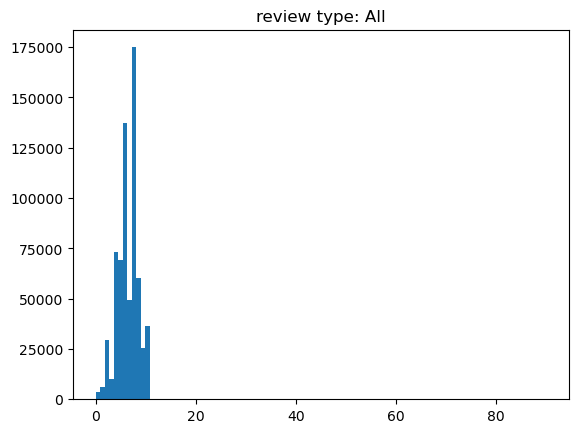

array([ 0. ,  0. ,  0. , ..., 87.5, 87.5, 90. ])

In [63]:
scores = eda.get_scores()
eda.show_hist(scores, bins=100, title="review type: All")
scores

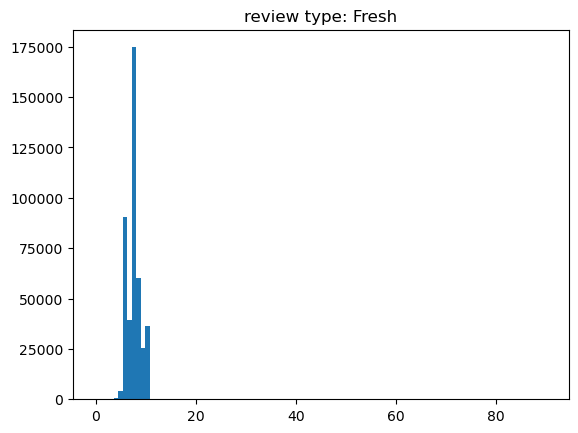

array([ 0. ,  0. ,  0. , ..., 87.5, 87.5, 90. ])

In [64]:
scores = eda.get_scores(review_type="Fresh")
eda.show_hist(scores, bins=100, title="review type: Fresh")
scores

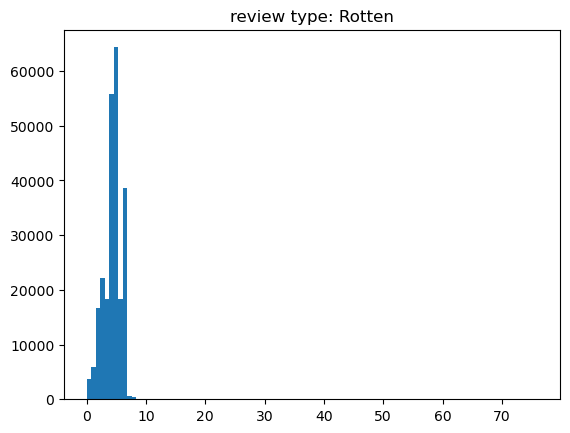

array([ 0.,  0.,  0., ..., 16., 18., 76.])

In [65]:
scores = eda.get_scores(review_type="Rotten")
eda.show_hist(scores, bins=100, title="review type: Rotten")
scores

In [66]:
label = eda.class_numbers(labels=['Fresh', 'Rotten'])
for l in label:
    print(f"{l}: {label[l]} ({label[l]/sum(label.values())*100:.0f}%)")

p = eda.number_of_na(col='review_score')/eda.__len__()
print(f"NA in review score: {p*100:.2f}%")

print()
print("### Statistic of All data ###")
for l in eda.all_stat:
    print(f"{l}:\t{eda.all_stat[l]:.3f}")

print()
print("### Statistic of Fresh data ###")
for l in eda.fresh_stat:
    print(f"{l}:\t{eda.fresh_stat[l]:.3f}")

print()
print("### Statistic of Rotten data ###")
for l in eda.rotten_stat:
    print(f"{l}:\t{eda.rotten_stat[l]:.3f}")

Fresh: 607346 (64%)
Rotten: 341835 (36%)
NA in review score: 28.84%

### Statistic of All data ###
len:	675478.000
score_mean:	6.487
score_median:	6.667
score_std:	2.075
score_min:	0.000
score_max:	90.000
texts_len_mean:	128.393
texts_len_median:	127.000
texts_len_std:	55.296
texts_len_min:	1.000
texts_len_max:	258.000
Fresh_number:	607346.000
Rotten_number:	341835.000

### Statistic of Fresh data ###
len:	430790.000
score_mean:	7.683
score_median:	7.778
score_std:	1.254
score_min:	0.000
score_max:	90.000
texts_len_mean:	130.019
texts_len_median:	129.000
texts_len_std:	55.437
texts_len_min:	1.000
texts_len_max:	257.000

### Statistic of Rotten data ###
len:	244688.000
score_mean:	4.382
score_median:	4.500
score_std:	1.471
score_min:	0.000
score_max:	76.000
texts_len_mean:	125.504
texts_len_median:	124.000
texts_len_std:	54.925
texts_len_min:	1.000
texts_len_max:	258.000


In [67]:
samples = eda.data.sample(10)
for c, t in zip(list(samples['review_content']), list(samples['review_type'])):
    print(f'##[{t}]##\n{c}')
    print("="*100)

##[Rotten]##
Beautifully shot and well-acted, but the romantic relationship at the movie's heart is unconvincing.
##[Fresh]##
The picture has a low-stakes, cop-show vitality to it; it doesn't pretend to be more than the sum of its parts.
##[Rotten]##
Too much surface and not enough depth.
##[Fresh]##
Where Spy Kids took the spy genre to adolescent levels, Catch that Kid does the same for the heist movie.
##[Fresh]##
Ethical dilemmas from every angle where the spectator is an accomplice. [Full review in Spanish]
##[Fresh]##
What it doesn't have: the adrenaline rush of total and complete surprise.
##[Fresh]##
Fincher is a master of kinetic razzle-dazzle, goosing familiar or trite material to life with his high-tech bag of tricks.
##[Rotten]##
A murky blend of melodrama and comedy.
##[Rotten]##
Like found footage horror movies? You'll change your mind after enduring the British import Hollow
##[Fresh]##
The torpid first half nearly made me drift into suspended animation. But the exciting 

In [87]:
cat={'pos': [], 'nat': [], 'neg': []}
for senti, score, t in zip(eda.data['review_type'], eda.data['review_score'], eda.data['review_content']):
    if score != score:
        cat['nat'].append(t)
    elif senti == 'Fresh' and score >= 7.9:
        cat['pos'].append(t)
    elif senti == 'Fresh' and score < 7.9:
        cat['nat'].append(t)
    else:
        cat['neg'].append(t)

len(cat['pos']), len(cat['nat']), len(cat['neg'])

(197605, 506888, 244688)